In [ ]:
# Module to get variable name as str
!pip3 install varname

In [ ]:
# Install kaggle to download dataset
! pip install kaggle

In [ ]:
# Load the TensorBoard notebook extension
#%load_ext tensorboard
# Reload TensorBoard
%reload_ext tensorboard

In [2]:
from datetime import datetime as dt
# from varname import argname
import os

# from google.colab import drive
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import zipfile

## Load data

In [ ]:
# Create a new directory in root
! mkdir ~/.kaggle

# Copy kaggle API token from Google Drive to the created directory
# To get API token: Login to Kaggle -> Account -> API -> Create New API Token (-> save in Google Drive for easier access)
!cp /content/drive/MyDrive/mida_deep_learning/kaggle.json ~/.kaggle/kaggle.json

# Download dataset from kaggle
!kaggle datasets download -d ayushv322/animal-classification

In [ ]:
# Extract dataset from zip to current session
zip_ref = zipfile.ZipFile('/content/animal-classification.zip', 'r') # Opens the zip file in read mode
zip_ref.extractall('/content')
zip_ref.close()

## Split Train-Val-Test

In [4]:
PATH = '../input/animal-classification/Data'
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# Split into train/test
# by default, class names are infered, and converted to int
train_dataset = tf.keras.utils.image_dataset_from_directory(directory = PATH,
                                                            validation_split=0.3,
                                                            subset='training',
                                                            shuffle=True,
                                                            seed=1,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(directory = PATH,
                                                                 validation_split=0.3,
                                                                 subset='validation',
                                                                 shuffle=True,
                                                                 seed=1,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 4000 files belonging to 4 classes.
Using 2800 files for training.


2022-04-05 05:13:12.982553: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-05 05:13:13.068371: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-05 05:13:13.069143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-05 05:13:13.071571: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 4000 files belonging to 4 classes.
Using 1200 files for validation.


In [5]:
# Create test dataset from validation dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 31
Number of test batches: 7


## Visualizing data

2022-04-05 05:13:25.061489: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


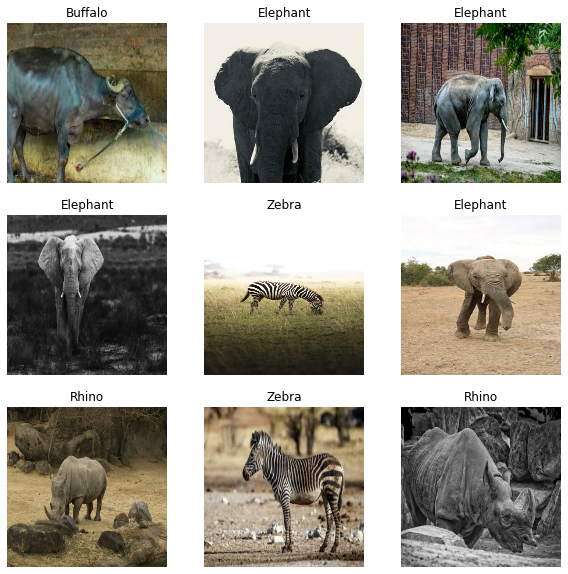

In [7]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [34]:
class_names

['Buffalo', 'Elephant', 'Rhino', 'Zebra']

## Configure dataset for performance

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Data augmentation

In [9]:
# Create a data augmentation model
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

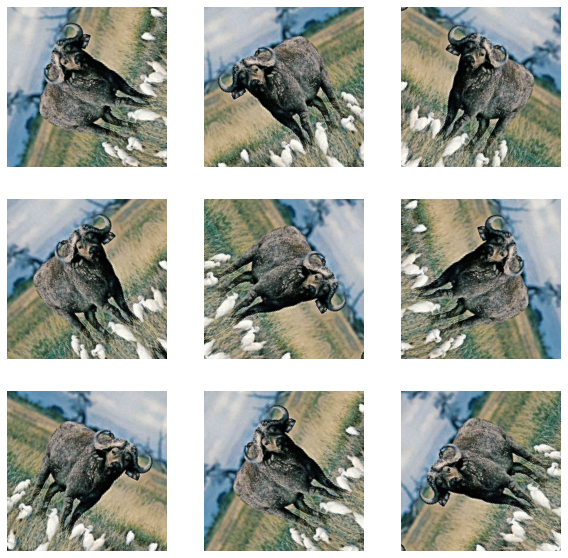

In [10]:
for image, _ in train_dataset.take(1): # Take 1 batch out
  plt.figure(figsize=(10, 10)) 
  first_image = image[0] # Take 1 image out from the batch
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255) # Rescale pixel value
    plt.axis('off')

## Preprocess input

In [35]:
# preprocess input using the function from the pre-trained model
preprocess_input = tf.keras.applications.vgg16.preprocess_input

## Create Base Model

In [79]:
# create base model from the pre-trained model
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights = 'imagenet')

In [49]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

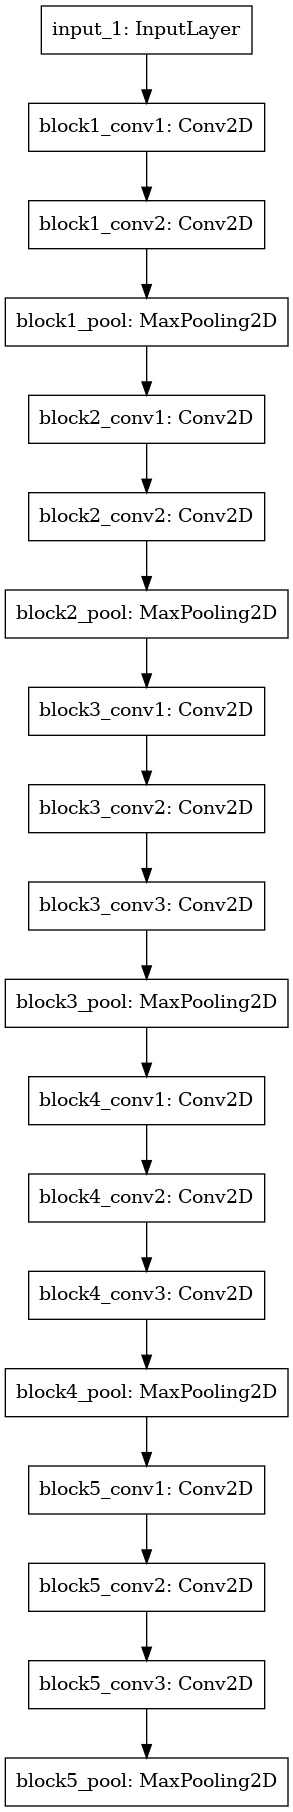

In [14]:
tf.keras.utils.plot_model(base_model)

In [80]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
# batchsize, width, height, layer
print(feature_batch.shape)

(32, 5, 5, 512)


In [82]:
# freeze the base model
base_model.trainable = False

In [83]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [84]:
# GlobalAveragePooling2D aggregate width and height into 1 dimension
# transforming the previous (32, 5, 5, 512) into (32, 512)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [41]:
len(class_names)

4

In [85]:
# Use the output as it is, no activation function
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [86]:
# use functional API to create the entire model, including the input pipeline and model
inputs = tf.keras.Input(shape=IMG_SHAPE) # shape can follow image shape
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.__operators__.getitem_4 ( (None, 160, 160, 3)       0         
_________________________________________________________________
tf.nn.bias_add_4 (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 512)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0   

In [87]:
# compile
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [88]:
# Get model performance before training
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)
print('loss:', loss0)
print('accuracy:', accuracy0)

31/31 [==============================] - 3s 58ms/step - loss: 6.7907 - accuracy: 0.2787
loss: 6.790738582611084
accuracy: 0.2786885201931


In [89]:
# train the last dense layer we added

logdir = os.path.join("logs", 'model')
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[tensorboard_callback])

2022-04-05 05:40:50.838108: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-05 05:40:50.838184: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-05 05:40:50.984667: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-05 05:40:50.984852: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Epoch 1/10
 2/88 [..............................] - ETA: 20s - loss: 6.7556 - accuracy: 0.3125 

2022-04-05 05:40:52.773792: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-05 05:40:52.773839: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-05 05:40:53.119367: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-05 05:40:53.119846: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-04-05 05:40:53.251972: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 186 callback api events and 183 activity events. 
2022-04-05 05:40:53.258344: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-05 05:40:53.269137: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/model/train/plugins/profile/2022_04_05_05_40_53

2022-04-05 05:40:53.274905: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzip

88/88 [==============================] - 8s 76ms/step - loss: 5.5904 - accuracy: 0.3257 - val_loss: 3.6595 - val_accuracy: 0.4959
Epoch 2/10
88/88 [==============================] - 7s 74ms/step - loss: 3.8803 - accuracy: 0.4307 - val_loss: 2.4855 - val_accuracy: 0.6240
Epoch 3/10
88/88 [==============================] - 7s 74ms/step - loss: 3.0481 - accuracy: 0.5025 - val_loss: 1.7346 - val_accuracy: 0.7111
Epoch 4/10
88/88 [==============================] - 6s 70ms/step - loss: 2.5037 - accuracy: 0.5761 - val_loss: 1.3769 - val_accuracy: 0.7510
Epoch 5/10
88/88 [==============================] - 7s 71ms/step - loss: 2.1088 - accuracy: 0.6246 - val_loss: 1.1737 - val_accuracy: 0.7910
Epoch 6/10
88/88 [==============================] - 6s 69ms/step - loss: 1.7745 - accuracy: 0.6636 - val_loss: 1.0056 - val_accuracy: 0.8145
Epoch 7/10
88/88 [==============================] - 7s 75ms/step - loss: 1.5936 - accuracy: 0.6911 - val_loss: 0.8489 - val_accuracy: 0.8453
Epoch 8/10
88/88 [======

## Fine tune
Goal: train the higher level convolutional layer. This is to allow high level features to be adapted to our own dataset.

In [90]:
# Unfreeze base model
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

# Compile using lower learning rate
# using RMSprop to have a more gradual learning
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.__operators__.getitem_4 ( (None, 160, 160, 3)       0         
_________________________________________________________________
tf.nn.bias_add_4 (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 512)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0   

In [91]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
88/88 [==============================] - 7s 71ms/step - loss: 1.2249 - accuracy: 0.7514 - val_loss: 0.5803 - val_accuracy: 0.8883
Epoch 11/20
88/88 [==============================] - 6s 69ms/step - loss: 1.1364 - accuracy: 0.7561 - val_loss: 0.5393 - val_accuracy: 0.8924
Epoch 12/20
88/88 [==============================] - 7s 77ms/step - loss: 1.2035 - accuracy: 0.7493 - val_loss: 0.6017 - val_accuracy: 0.8842
Epoch 13/20
88/88 [==============================] - 7s 71ms/step - loss: 1.1561 - accuracy: 0.7639 - val_loss: 0.5397 - val_accuracy: 0.8924
Epoch 14/20
88/88 [==============================] - 6s 69ms/step - loss: 1.1355 - accuracy: 0.7650 - val_loss: 0.5444 - val_accuracy: 0.8893
Epoch 15/20
88/88 [==============================] - 7s 69ms/step - loss: 1.1483 - accuracy: 0.7611 - val_loss: 0.5256 - val_accuracy: 0.8934
Epoch 16/20
88/88 [==============================] - 7s 71ms/step - loss: 1.1322 - accuracy: 0.7607 - val_loss: 0.5504 - val_accuracy: 0.8934
Epoch 

## Evaluation and prediction

In [92]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

7/7 [==============================] - 1s 48ms/step - loss: 0.3681 - accuracy: 0.9196
Test accuracy : 0.9196428656578064


## Deploy

Predictions:
 [0 0 3 3 3 2 2 1 3 3 2 3 1 2 3 0 0 2 2 1 3 2 2 2 0 1 1 2 3 0 3 3]
Labels:
 [0 0 3 3 3 2 1 1 2 3 2 3 1 0 3 0 0 2 2 1 3 2 2 2 0 1 1 2 3 0 3 3]


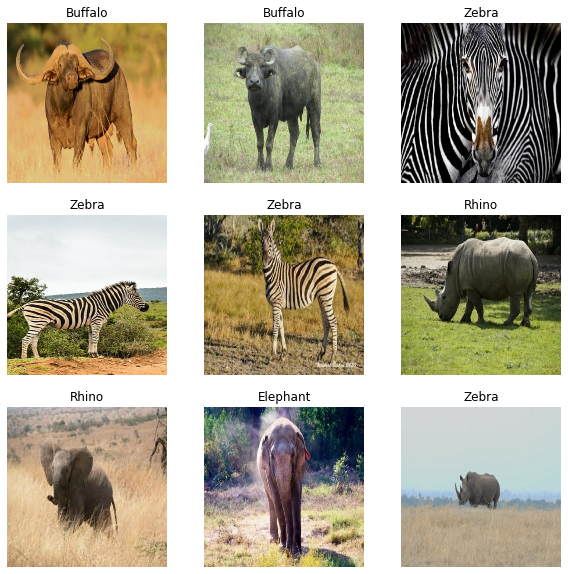

In [129]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch) # predict on 1 batch
pred_label = np.argmax(predictions, axis=1) # get the class index with max predictions

# compare prediction and labels
print('Predictions:\n', pred_label)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[pred_label[i]])
  plt.axis("off")